In [2]:
import gym
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from collections import defaultdict
from numba import njit

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

#from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

OPEN AI GYM BlackJack
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

In [3]:
bjenv = gym.make('Blackjack-v0')
bjenv.reset()

(15, 8, True)

In [4]:
bjenv.step(bjenv.action_space.sample()) # take a random action


((12, 8, False), 0.0, False, {})

In [5]:
bjenv.close()

## Value iteration по уравнениям Беллмана

## First-visit Monte Carlo по состояниям


In [6]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    hit = 1
    stick = 0
    return stick if score >= 19 else hit

In [7]:
def run_episode(pi, env):
    observation = env.reset() 
    states, actions, rewards = [], [], []
    while True:
        states.append(observation)
        action = pi(observation)
        actions.append(action)
        
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
              break
    return states, actions, rewards

def run_episode_with_policy(pi, env):
    observation = env.reset() 
    states, actions, rewards = [], [], []
    while True:
        states.append(observation)
        action = pi[observation]
        actions.append(action)
        
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
              break
    return states, actions, rewards


def get_reward_episode(pi, env):
    states, _, rewards = run_episode_with_policy(pi, env)
    return rewards[-1]

def estimate_policy(env, policy, total_episodes):
    total_reward = 0
    for _ in range(total_episodes):
        reward = get_reward_episode(policy, env)
        total_reward += reward
    
    return total_reward / total_episodes



def update_returns(N, states, value_table):
    returns = 0

    for t in range(len(states) -1, -1, -1):
        R = rewards[t]
        S = states[t]
        returns += R

        if S not in states[:t]:
            N[S] += 1
            value_table[S] += (returns - value_table[S]) / N[S]
    

In [8]:
def first_visit_mc_prediction(policy, env, total_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    for _ in range(total_episodes):
        states, _, rewards = run_episode(policy, env)
        returns = 0

        for t in range(len(states) -1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R

            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    return value_table

In [9]:
env = gym.make('Blackjack-v0')
value = first_visit_mc_prediction(sample_policy, env, total_episodes=500000)
for i in range(10):
    print(value.popitem())

    

((4, 3, False), -0.2904761904761905)
((12, 6, True), -0.05022831050228318)
((4, 9, False), -0.2974137931034481)
((16, 1, True), -0.38605442176870763)
((18, 3, True), -0.2347600518806738)
((4, 2, False), -0.19230769230769232)
((4, 1, False), -0.5991189427312775)
((4, 5, False), -0.18502202643171803)
((13, 4, True), -0.020491803278688513)
((5, 9, False), -0.3626373626373624)


In [12]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 22)
    dealer_show = np.arange(1, 11)         
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    X, Y = np.meshgrid(player_sum, dealer_show)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])   
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:    
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer show')
        ax.set_zlabel('state-value')

fig, axes = plt.subplots(nrows=2, figsize=(10, 10),subplot_kw={'projection': '3d'})
axes[0].set_title('state-value distribution w/o usable ace')
axes[1].set_title('state-value distribution w/ usable ace')
plot_blackjack(value, axes[0], axes[1])

ValueError: Unknown projection '3d'

<Figure size 720x720 with 0 Axes>

## Monte-Carlo control с on-policy исследованием

In [13]:

def compute_policy_by_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [14]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    mean_reward = np.zeros(num_episodes)
    for i_episode in range(1, num_episodes+1):
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = compute_policy_by_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
        cur_policy = dict((k,np.argmax(v)) for k, v in Q.items())
        if i_episode < 10000:
            continue
        cur_estimation = estimate_policy(env, cur_policy, 50000)
        mean_reward[i_episode - 1] = cur_estimation
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, mean_reward

In [ ]:
policy, Q, mean_reward= mc_control(env, 100000, 0.02)

Episode 91500/100000.

In [39]:
cur_estimation = estimate_policy(env, policy, 100000)

-0.07281

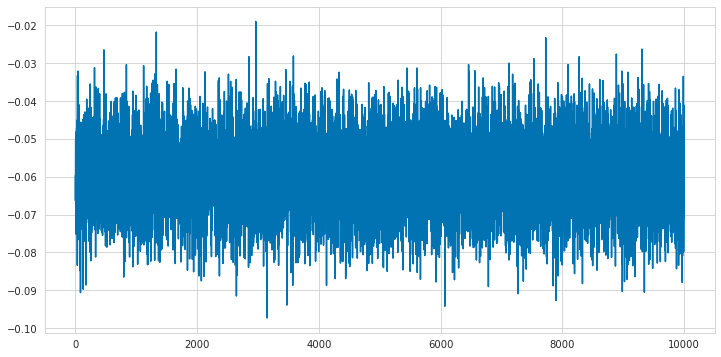

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(mean_reward)

-0.06397